## FiX DATA

In [442]:
import json

f = open("../data/label_ner_1_1015.json")


def adding_space(s):
    single_description = s.lower().strip()
    new_description = []
    last_special = -1
    for idx, letter in enumerate(single_description):
        if not (('a' <= letter and letter <= 'z') or ('0' <= letter and letter <= '9') or letter == ' '):
            pretext = single_description[last_special + 1:idx].strip()
            if pretext != '' and pretext != ' ':
                new_description.append(pretext)
            new_description.append(letter.strip())
            last_special = idx
        if idx == len(single_description) - 1:
            new_description.append(
                single_description[last_special + 1:idx + 1].strip())

    new_description = ' '.join(new_description).lower().strip()
    return new_description


list_data = json.load(f)
list_sentence = []
list_locs = []
list_words = []
list_id = []
debug_id = None
for i_list_data, data in enumerate(list_data):
    if debug_id is not None and i_list_data == debug_id:
        print(list_data[debug_id]['data']['text'])
    original_description = data['data']['text']
    original_annotations = data['annotations']

    new_description = adding_space(original_description)
    if debug_id is not None and i_list_data == debug_id:
        print(new_description)
    locs = []
    words = []
    set_new_locations = set()
    for annotation in original_annotations:
        results = annotation['result']
        for ia, result in enumerate(results):
            label = result['value']['labels'][0]
            org_start = result['value']['start']
            org_end = result['value']['end']
            org_word = result['value']['text'].lower().strip()
            new_word = adding_space(org_word)
            if debug_id is not None and i_list_data == debug_id:
                # print(new_word)
                pass
            word_len = len(new_word)
            new_start = None
            new_end = None
            # find_res = new_description[org_start:].find(new_word)
            if debug_id is not None and i_list_data == debug_id:
                print("Finding word: ", new_word)
                print("Finding pool: ", new_description[org_start:])
            for i in range(org_start, len(new_description)):
                # if debug_id is not None and new_word == 'boy':
                #     print(new_description[i:i+word_len])
                if new_description[i:i+word_len] == new_word and (i, i+word_len) not in set_new_locations:
                    if i - 1 >= 0 and 'a' <= new_description[i - 1].lower() and new_description[i - 1].lower() <= 'z':
                        continue
                    if i + word_len < len(new_description) and 'a' <= new_description[i + word_len].lower() and new_description[i + word_len].lower() <= 'z':
                        continue
                    new_start = i
                    new_end = i + word_len
                    set_new_locations.add((new_start, new_end))
                    list_data[i_list_data]['annotations'][0]['result'][ia]['value']['text'] = new_word
                    list_data[i_list_data]['annotations'][0]['result'][ia]['value']['start'] = new_start
                    list_data[i_list_data]['annotations'][0]['result'][ia]['value']['end'] = new_end
                    if debug_id is not None and i_list_data == debug_id:
                        print("Founded word: ", new_description[new_start:new_end])
                        pass
                    break
    list_data[i_list_data]['data']['text'] = new_description
    if len(set_new_locations) != len(annotation['result']):
        # print(set_new_locations)
        # display(annotation['result'])
        print("Wrong relabeled data: ", i_list_data)
        # print(original_description)
        # print(new_description)
        # display(original_annotations)
        # print(set_new_locations)
        # display(annotation['result'])
        continue

In [443]:
with open("../data/label_ner_1_1015_fixed.json", "w") as outfile:
    json.dump(list_data, outfile)

## TRAIN BERT

In [1]:
import torch
import pandas as pd

print("CUDA: ", torch.cuda.is_available())

CUDA:  True


In [2]:
from transformers import AutoTokenizer

# https://huggingface.co/docs/transformers/tasks/token_classification
# model_checkpoint = "distilbert-base-uncased"
# model_checkpoint = "./bert-finetuned-ner"
# model_checkpoint = "bert-base-cased"
# model_checkpoint = "dslim/bert-base-NER"
# model_checkpoint = "roberta-base"
model_checkpoint = "microsoft/deberta-v3-large"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/tanluuuuuuu/miniconda3/envs/one_for_all/lib/python3.8/site-packages/transformers/convert_slow_tokenizer.py:454: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:
REMOVE_LABELS = ['AGE_GROUP', 'GENDER', 'FEATURE', 'TARGET_USAGE', 'MAIN_PRODUCT', 'COMPONENT']

In [4]:
ner_tags_doccano = [
    {
        "id": 6,
        "text": "MAT",

    },
    {
        "id": 7,
        "text": "NMAT",

    },
    {
        "id": 8,
        "text": "DIMENSION",

    },
    {
        "id": 11,
        "text": "COMPONENT",

    },
    {
        "id": 13,
        "text": "MAIN_PRODUCT",

    },
    {
        "id": 14,
        "text": "WEIGHT",

    },
    {
        "id": 15,
        "text": "TARGET_USER",

    },
    {
        "id": 17,
        "text": "PROPERTY",

    },
    {
        "id": 18,
        "text": "COLOR",

    },
    {
        "id": 19,
        "text": "SHAPE",

    }
]

processed_ner_tags = ['O']
for tag in ner_tags_doccano:
    if tag['text'] not in REMOVE_LABELS:
        processed_ner_tags.append(f"B-{tag['text']}")
        processed_ner_tags.append(f"I-{tag['text']}")
        print(tag['text'])
    else:
        print(tag['text'])

print(processed_ner_tags)
print(len(processed_ner_tags))

ner_tags_2_number = {t: i for (i, t) in enumerate(processed_ner_tags)}
number_2_ner_tags = {t: i for (t, i) in enumerate(ner_tags_2_number)}

MAT
NMAT
DIMENSION
COMPONENT
MAIN_PRODUCT
WEIGHT
TARGET_USER
PROPERTY
COLOR
SHAPE
['O', 'B-MAT', 'I-MAT', 'B-NMAT', 'I-NMAT', 'B-DIMENSION', 'I-DIMENSION', 'B-WEIGHT', 'I-WEIGHT', 'B-TARGET_USER', 'I-TARGET_USER', 'B-PROPERTY', 'I-PROPERTY', 'B-COLOR', 'I-COLOR', 'B-SHAPE', 'I-SHAPE']
17


In [5]:
import json
from collections import Counter
import pandas as pd

# file_path = '../data/label_studio_1017_shorter.json'
label_counter = Counter()

def read_data_json(list_file_path):
    list_data = []
    for file_path in list_file_path:
        f = open(file_path)

        list_data += json.load(f)

    list_sentence = []
    list_locs = []
    list_words = []
    for i, data in enumerate(list_data):
        text = data['data']['text']
        annotations = data['annotations']
        locs = []
        words = []
        for annotation in annotations:
            results = annotation['result']
            for result in results:
                start = result['value']['start']
                end = result['value']['end']
                label = result['value']['labels'][0]

                if label not in REMOVE_LABELS:
                    label_counter[label] += 1
                    locs.append((str(start), str(end), str(label)))
                    words.append(text[start:end])

        list_sentence.append(text)
        list_locs.append(locs)
        list_words.append(words)

    raw_dataset = pd.DataFrame()
    raw_dataset['sentence'] = pd.Series(list_sentence)
    raw_dataset['locs'] = pd.Series(list_locs)
    raw_dataset['words'] = pd.Series(list_words)

    raw_dataset.to_excel("./raw_dataset.xlsx", index=False)
    return raw_dataset

def read_data_colnn(file_path):
    file_colnn = open(file_path, 'r')
    lines = file_colnn.readlines()

    list_words = []
    list_labels = []

    word_pieces = []
    label_pieces = []

    for line in lines:
        line = line.strip()
        line_split = line.split(" ")

        if line_split[0] == "-DOCSTART-":
            continue
        elif line_split[0] == "":
            list_words.append(word_pieces)
            list_labels.append(label_pieces)

            word_pieces = []
            label_pieces = []
            continue

        word = line_split[0]
        label = line_split[3]

        if label in REMOVE_LABELS:
            label = "O"
            
        label = ner_tags_2_number[label]

        word_pieces.append(word)
        label_pieces.append(label)

    raw_dataset = pd.DataFrame()
    raw_dataset['tokens'] = pd.Series(list_words)
    raw_dataset['ner_tags'] = pd.Series(list_labels)
    return raw_dataset

raw_dataset = read_data_json(["../data/label_ner_1_1015_fixed.json", 
                               "../data/label_ner_2_1044.json"])
display(raw_dataset)

,sentence,locs,words
0,👍 【 folding & portable rebounder 】 the jump tr...,"[(4, 11, PROPERTY), (14, 32, PROPERTY), (222, ...","[folding, portable rebounder, portable]"
1,uv printing,"[(0, 2, MAT)]",[uv]
2,premium eco friendly material with no odor : o...,"[(123, 133, NMAT), (50, 66, PROPERTY), (35, 42...","[phthalates, non - allergenic, no odor, non - ..."
3,"boxing speed ball : pu material speed ball , c...","[(20, 22, MAT), (105, 118, PROPERTY), (79, 89,...","[pu, without sound, 90 degrees, rebound]"
4,weighs 100 lbs,"[(7, 14, WEIGHT)]",[100 lbs]
...,...,...,...
2053,uv protection : light filtering soft sail shad...,"[(16, 31, PROPERTY), (32, 54, PROPERTY), (66, ...","[light filtering, soft sail shade canopy, soft..."
2054,powered up : exclusive removable powerport fea...,"[(23, 32, PROPERTY), (52, 72, PROPERTY), (77, ...","[removable, 3 electrical outlets, 3 usb ports]"
2055,steel anchoring plates : powder coated steel a...,"[(0, 22, PROPERTY), (25, 61, PROPERTY), (72, 9...","[steel anchoring plates, powder coated steel a..."
2056,easy assembly : supported by step - by - step ...,"[(58, 66, PROPERTY)]",[bilt app]


In [6]:
label_counter

Counter({'PROPERTY': 2964,
         'MAT': 647,
         'NMAT': 170,
         'WEIGHT': 201,
         'TARGET_USER': 762,
         'DIMENSION': 515,
         'COLOR': 112,
         'SHAPE': 28})

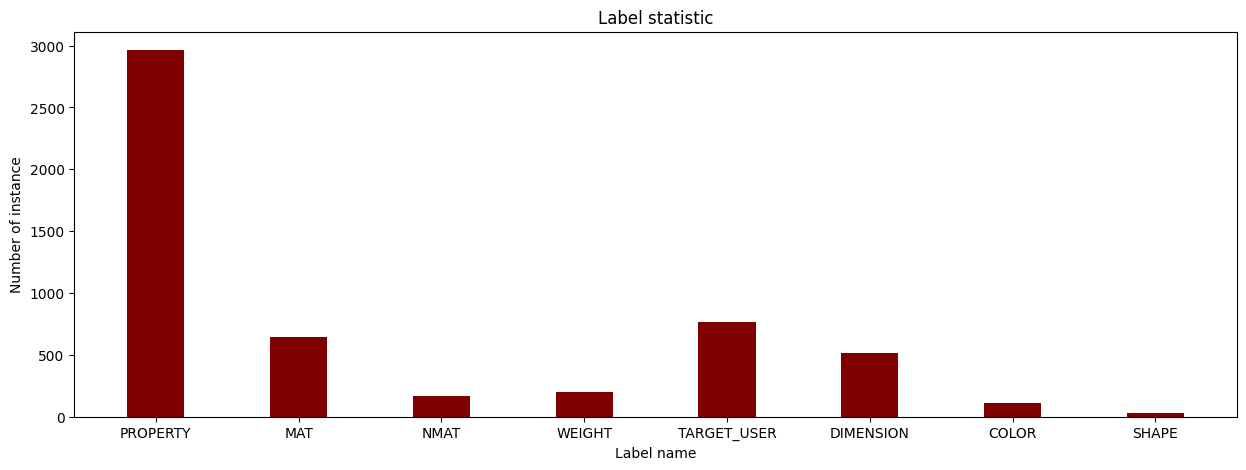

In [7]:
import numpy as np
import matplotlib.pyplot as plt


# creating the dataset
courses = list(label_counter.keys())
values = list(label_counter.values())



fig = plt.figure(figsize = (15, 5))

# creating the bar plotlabel_studio_1017_shorter.json
plt.bar(courses, values, color ='maroon',
		width = 0.4)

plt.xlabel("Label name")
plt.ylabel("Number of instance")
plt.title("Label statistic")
plt.show()


In [8]:
raw_dataset.loc[0]

sentence    👍 【 folding & portable rebounder 】 the jump tr...
locs        [(4, 11, PROPERTY), (14, 32, PROPERTY), (222, ...
words                 [folding, portable rebounder, portable]
Name: 0, dtype: object

In [9]:
from datasets import Dataset, DatasetDict, ClassLabel, Features, Value, Sequence

train_dataset = Dataset.from_pandas(raw_dataset)
val_dataset = Dataset.from_pandas(raw_dataset)
test_dataset = Dataset.from_pandas(raw_dataset)

raw_datasets = DatasetDict(
    {"train": train_dataset, "val": val_dataset, "test": test_dataset})
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['sentence', 'locs', 'words'],
        num_rows: 2058
    })
    val: Dataset({
        features: ['sentence', 'locs', 'words'],
        num_rows: 2058
    })
    test: Dataset({
        features: ['sentence', 'locs', 'words'],
        num_rows: 2058
    })
})

In [10]:
def visualize_ner_tags(words, labels):
    line1 = ""
    line2 = ""
    for word, label in zip(words, labels):
        # print(word, label)
        label = str(label)
        max_length = max(len(word), len(label))
        line1 += word + " " * (max_length - len(word) + 1)
        line2 += label + " " * (max_length - len(label) + 1)
    print(line1)
    print(line2)

In [11]:
import ast


def assign_ner_tags_bert(example):
    # print(example['sentence'])
    token_input = tokenizer(example['sentence'])
    example['tokens'] = tokenizer.convert_ids_to_tokens(
        token_input['input_ids'])

    # print(example['sentence'])
    # print(example['tokens'])
    # print("len: ", len(example['tokens']))

    ner_tags = [0 for token in example['tokens']]
    if str(type(example['locs'])) == "<class 'list'>":
        locs = example['locs']
    else:
        locs = ast.literal_eval(example['locs'])

    locs = [(int(loc[0]), int(loc[1]), loc[2]) for loc in locs]
    locs = sorted(locs)
    # print(locs)
    bg_id = 1
    pre_loc = 0
    text = example['sentence']
    for loc in locs:
        loc0 = int(loc[0])
        loc1 = int(loc[1])

        # print(text[loc0:loc1])
        # print(loc0 - pre_loc)

        pre_text = text[pre_loc:loc0]
        token_input = tokenizer(pre_text)
        pre_token = tokenizer.convert_ids_to_tokens(
            token_input['input_ids'])

        # print(pre_text)
        # print(pre_token)
        # print("len: ", len(pre_token))

        bg_id = bg_id + len(pre_token) - 2
        pre_loc = loc1

        # print("bg_id: ", bg_id)

        word = example['sentence'][loc0: loc1]
        token_input = tokenizer(word)
        word_token = tokenizer.convert_ids_to_tokens(token_input['input_ids'])

        # print("Word: ", word)
        # print(word_token)
        # print("len: ", len(word_token))

        # print(example['tokens'][bg_id])

        label_number = ner_tags_2_number[f"B-{loc[2]}"]
        ner_tags[bg_id] = label_number
        bg_id += 1
        for idx in range(bg_id, bg_id + len(word_token) - 3):
            ner_tags[idx] = label_number + 1
        bg_id = bg_id + len(word_token) - 3

        # visualize_ner_tags(example['tokens'], ner_tags)

    ner_tags[0] = -100
    ner_tags[-1] = -100
    return ner_tags

def assign_ner_tags_deberta(example):
    # print(example['sentence'])
    token_input = tokenizer(example['sentence'])
    example['tokens'] = tokenizer.convert_ids_to_tokens(
        token_input['input_ids'])

    # print(example['sentence'])
    # print(example['tokens'])
    # print("len: ", len(example['tokens']))

    ner_tags = [0 for token in example['tokens']]
    if str(type(example['locs'])) == "<class 'list'>":
        locs = example['locs']
    else:
        locs = ast.literal_eval(example['locs'])

    locs = [(int(loc[0]), int(loc[1]), loc[2]) for loc in locs]
    locs = sorted(locs)
    # print(locs)
    bg_id = 1
    pre_loc = 0
    text = example['sentence']
    for loc in locs:
        loc0 = int(loc[0])
        loc1 = int(loc[1])

        pre_text = text[pre_loc:loc0]
        token_input = tokenizer(pre_text)
        pre_token = tokenizer.convert_ids_to_tokens(
            token_input['input_ids'])

        # print(pre_text)
        # print(pre_token)
        # print("len: ", len(pre_token))

        bg_id = bg_id + len(pre_token) - 2
        pre_loc = loc1

        # print("bg_id: ", bg_id)

        word = example['sentence'][loc0: loc1]
        token_input = tokenizer(word)
        word_token = tokenizer.convert_ids_to_tokens(token_input['input_ids'])

        # print("Word: ", word)
        # print(word_token)
        # print("len: ", len(word_token))

        label_number = ner_tags_2_number[f"B-{loc[2]}"]
        ner_tags[bg_id] = label_number
        bg_id += 1
        for idx in range(bg_id, bg_id + len(word_token) - 3):
            ner_tags[idx] = label_number + 1
        bg_id = bg_id + len(word_token) - 3

        # visualize_ner_tags(example['tokens'], ner_tags)

    ner_tags[0] = -100
    ner_tags[-1] = -100
    return ner_tags

def assign_ner_tags_roberta(example):

    token_input = tokenizer(example['sentence'])
    example['tokens'] = tokenizer.convert_ids_to_tokens(
        token_input['input_ids'])

    ner_tags = [0 for token in example['tokens']]
    if str(type(example['locs'])) == "<class 'list'>":
        locs = example['locs']
    else:
        locs = ast.literal_eval(example['locs'])

    locs = [(int(loc[0]), int(loc[1]), loc[2]) for loc in locs]
    locs = sorted(locs)
    bg_id = 1
    pre_loc = 0
    text = example['sentence']
    for loc in locs:
        loc0 = int(loc[0])
        loc1 = int(loc[1])

        pre_text = text[pre_loc:loc0]
        if 0 < loc0 and len(pre_text) > 0 and pre_text[-1] == ' ':
            pre_text = text[pre_loc:loc0 - 1] 
        token_input = tokenizer(pre_text)
        pre_token = tokenizer.convert_ids_to_tokens(
            token_input['input_ids'])
        bg_id = bg_id + len(pre_token) - 2
        pre_loc = loc1

        word = example['sentence'][loc0: loc1].strip()
        if loc0 > 0 and example['sentence'][loc0 - 1] == ' ':
            word = " " + word
        token_input = tokenizer(word)
        word_token = tokenizer.convert_ids_to_tokens(token_input['input_ids'])
        
        label_number = ner_tags_2_number[f"B-{loc[2]}"]
        ner_tags[bg_id] = label_number
        bg_id += 1
        for idx in range(bg_id, bg_id + len(word_token) - 3):
            ner_tags[idx] = label_number + 1
        bg_id = bg_id + len(word_token) - 3

        # visualize_ner_tags(example['tokens'], ner_tags)

    ner_tags[0] = -100
    ner_tags[-1] = -100
    return ner_tags

In [12]:
id = 42
print(raw_datasets['train'][id]['sentence'])
# print(raw_datasets['train'][id]['sentence'][227:230])
token_input = tokenizer(raw_datasets['train'][id]['sentence'])
# token_input = tokenizer('👍 【 folding & portable rebounder 】')
print(token_input)
words = tokenizer.convert_ids_to_tokens(token_input['input_ids'])
print(words)
labels = assign_ner_tags_deberta(raw_datasets['train'][id])

visualize_ner_tags(words, labels)

💪 【 portable and lightweight 】 easy to remove high quality elastic tension training equipment this product is very soft , absorbent and slip resistant . exercise your arms , legs and back for sitting exercises . suitable for women , men , the elderly , children . shoulder exercises ; hand exercises ; at home , hotel rooms , offices and even outdoor private leg exercises . suitable for cross fitter leadership pull - ups , muscle exercise , physical therapy , stretching exercises , strength training , etc .
{'input_ids': [1, 507, 123306, 41131, 5480, 263, 6577, 507, 34243, 639, 264, 1963, 459, 607, 12323, 5930, 838, 1324, 291, 714, 269, 379, 2052, 366, 34712, 263, 6187, 7038, 323, 2111, 290, 3010, 366, 3467, 263, 396, 270, 2386, 5479, 323, 2714, 270, 694, 366, 842, 366, 262, 6891, 366, 572, 323, 4103, 5479, 2600, 721, 5479, 2600, 288, 425, 366, 1612, 2382, 366, 4030, 263, 402, 2547, 1094, 3540, 5479, 323, 2714, 270, 1943, 44239, 2297, 2647, 341, 322, 268, 366, 3675, 2111, 366, 1468, 2773

In [13]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["sentence"], truncation=True, is_split_into_words=False
    )
    tokenized_inputs["labels"] = assign_ner_tags_bert(examples)
    return tokenized_inputs

In [14]:
from datasets import Dataset

list_input_ids = []
list_token_type_ids = []
list_attention_mask = []
list_labels = []

for index, row in raw_dataset.iterrows():
    try:
        label = assign_ner_tags_deberta(row)
        token_input = tokenizer(row['sentence'])
        list_input_ids.append(token_input['input_ids'])
        # list_token_type_ids.append(token_input['token_type_ids'])
        list_attention_mask.append(token_input['attention_mask'])
        list_labels.append(label)
    except Exception as error:
        # print(error)
        print(index)
        print(row['sentence'])

tokenized_datasets = pd.DataFrame()
tokenized_datasets['input_ids'] = pd.Series(list_input_ids)
# tokenized_datasets['token_type_ids'] = pd.Series(list_token_type_ids)
tokenized_datasets['attention_mask'] = pd.Series(list_attention_mask)
tokenized_datasets['labels'] = pd.Series(list_labels)

train_dataset = Dataset.from_pandas(tokenized_datasets)
val_dataset = Dataset.from_pandas(tokenized_datasets)
test_dataset = Dataset.from_pandas(tokenized_datasets)

tokenized_datasets = DatasetDict(
    {"train": train_dataset, "val": val_dataset, "test": test_dataset})
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2058
    })
    val: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2058
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2058
    })
})

In [15]:
tokenized_datasets = tokenized_datasets['train'].train_test_split(test_size=0.2, shuffle=True, seed=7)
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1646
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 412
    })
})

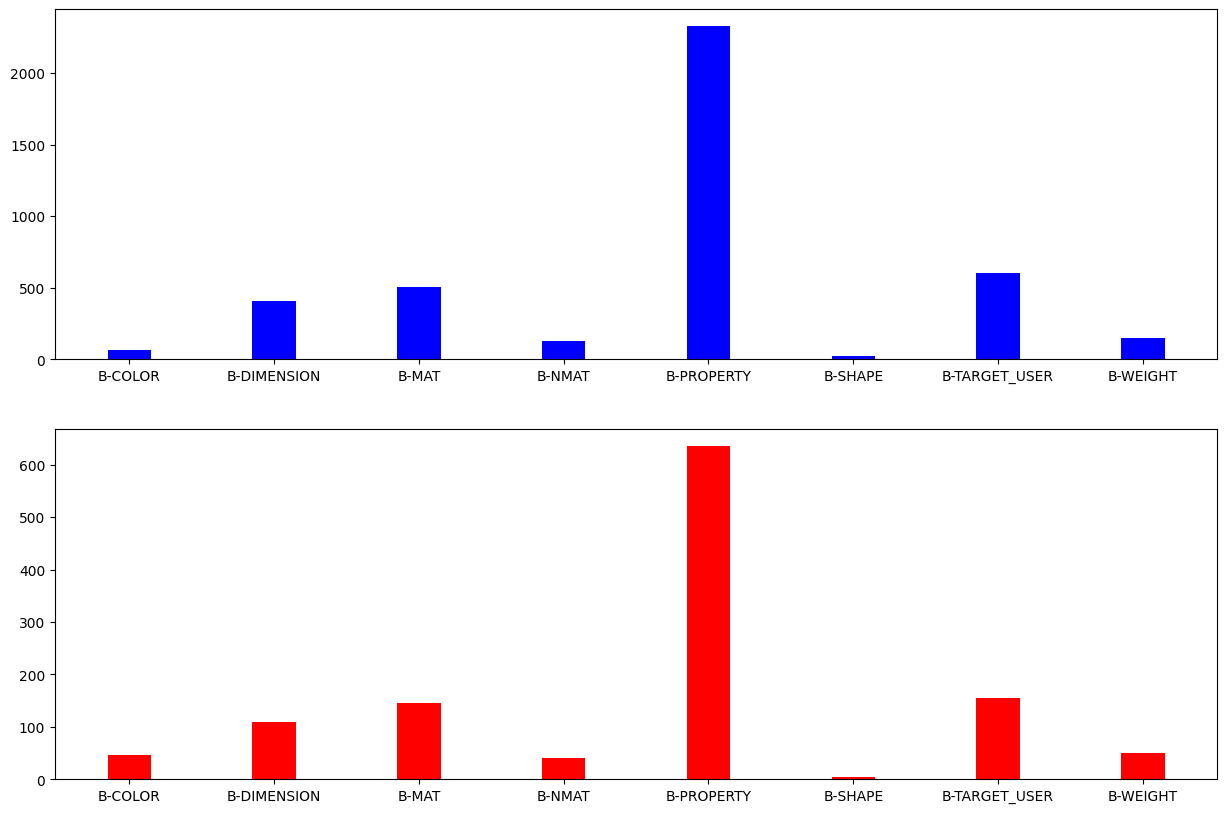

In [16]:
import numpy as np
import matplotlib.pyplot as plt

count_train = Counter()
count_test = Counter()

for test_line in tokenized_datasets['train']:
    for label in test_line['labels']:
        if label in number_2_ner_tags and label != 0 and number_2_ner_tags[label][0] == 'B':
            count_train[number_2_ner_tags[label]] += 1

for test_line in tokenized_datasets['test']:
    for label in test_line['labels']:
        if label in number_2_ner_tags and label != 0 and number_2_ner_tags[label][0] == 'B':
            count_test[number_2_ner_tags[label]] += 1

myKeys = list(count_train.keys())
myKeys.sort()
count_train_sorted = {i: count_train[i] for i in myKeys}
count_test_sorted = {i: count_test[i] for i in myKeys}

figure, axis = plt.subplots(2, 1, figsize = (15, 10))

# creating the dataset
courses_train = list(count_train_sorted.keys())
values_train = list(count_train_sorted.values())

# creating the bar plotlabel_studio_1017_shorter.json
axis[0].bar(courses_train, values_train, color ='blue',
		width = 0.3)
axis[0].set_title = "Train statistics"

# creating the dataset
courses_test = list(count_test_sorted.keys())
values_test = list(count_test_sorted.values())

# creating the bar plotlabel_studio_1017_shorter.json
axis[1].bar(courses_test, values_test, color ='red',
		width = 0.3)
axis[1].set_title = "Val/Test statistics"

plt.show()


In [17]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

2023-09-25 13:47:30.899696: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-25 13:47:30.921216: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-25 13:47:31.324806: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [18]:
import evaluate

metric = evaluate.load("seqeval")

In [19]:
import numpy as np

label_names = processed_ner_tags
id2label = {i: label for i, label in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": all_metrics["overall_precision"],
        "recall": all_metrics["overall_recall"],
        "f1": all_metrics["overall_f1"],
        "accuracy": all_metrics["overall_accuracy"],
    }

In [20]:
from transformers import AutoModelForTokenClassification
# Modify code in heare
from transformers.models.bert import modeling_bert

model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)
model.config.num_labels

Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2ForTokenClassification: ['lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'deberta.embeddings.position_embeddings.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2ForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a B

17

## Custom Traning loop

In [21]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=4,
)
eval_dataloader = DataLoader(
    tokenized_datasets["test"], collate_fn=data_collator, batch_size=8
)

In [22]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=2e-5)

In [23]:
from accelerate import Accelerator

accelerator = Accelerator()
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

In [24]:
def postprocess(predictions, labels):
    predictions = predictions.detach().cpu().clone().numpy()
    labels = labels.detach().cpu().clone().numpy()

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    return true_labels, true_predictions

In [25]:
from transformers import get_scheduler

num_train_epochs = 50
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

In [26]:
from tqdm.auto import tqdm
import torch

output_dir = f"./deberta-v3-large_v5_{num_train_epochs}e_split"
progress_bar = tqdm(range(num_training_steps))

best_f1_score = 0

for epoch in range(num_train_epochs):
    # Training
    model.train()
    for batch in train_dataloader:
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    # Evaluation
    model.eval()
    for batch in eval_dataloader:
        with torch.no_grad():
            outputs = model(**batch)

        predictions = outputs.logits.argmax(dim=-1)
        labels = batch["labels"]

        # Necessary to pad predictions and labels for being gathered
        predictions = accelerator.pad_across_processes(predictions, dim=1, pad_index=-100)
        labels = accelerator.pad_across_processes(labels, dim=1, pad_index=-100)

        predictions_gathered = accelerator.gather(predictions)
        labels_gathered = accelerator.gather(labels)

        true_predictions, true_labels = postprocess(predictions_gathered, labels_gathered)
        metric.add_batch(predictions=true_predictions, references=true_labels)

    results = metric.compute()
    print(
        f"epoch {epoch}:",
        {
            key: results[f"overall_{key}"]
            for key in ["precision", "recall", "f1", "accuracy"]
        },
    )

    # Save and upload
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
    if accelerator.is_main_process and results[f"overall_f1"] > best_f1_score:
        best_f1_score = results[f"overall_f1"]
        print(f"Save model at epoch {epoch} with better f1 score {best_f1_score}")
        tokenizer.save_pretrained(output_dir)
        unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)

  0%|          | 0/20600 [00:00<?, ?it/s]

You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/tanluuuuuuu/miniconda3/envs/one_for_all/lib/python3.8/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch 0: {'precision': 0.6296296296296297, 'recall': 0.5776061776061776, 'f1': 0.6024969794603302, 'accuracy': 0.929671269705487}
Save model at epoch 0 with better f1 score 0.6024969794603302
epoch 1: {'precision': 0.6885521885521886, 'recall': 0.6908783783783784, 'f1': 0.6897133220910623, 'accuracy': 0.9447024318709519}
Save model at epoch 1 with better f1 score 0.6897133220910623
epoch 2: {'precision': 0.7146464646464646, 'recall': 0.68578352180937, 'f1': 0.6999175597691673, 'accuracy': 0.9448246364414029}
Save model at epoch 2 with better f1 score 0.6999175597691673
epoch 3: {'precision': 0.7112794612794613, 'recall': 0.6798069187449718, 'f1': 0.6951871657754011, 'accuracy': 0.9439692044482464}
epoch 4: {'precision': 0.7138047138047138, 'recall': 0.7399650959860384, 'f1': 0.726649528706084, 'accuracy': 0.9448857387266284}
Save model at epoch 4 with better f1 score 0.726649528706084
epoch 5: {'precision': 0.7205387205387206, 'recall': 0.6777513855898654, 'f1': 0.6984904120767034, 'ac

In [ ]:
# accelerator.wait_for_everyone()
# unwrapped_model = accelerator.unwrap_model(model)
# unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)

## Built-in traning loop

In [21]:
from transformers import TrainingArguments

model_name = 'bert-base-NER_v4_30e_split'
args = TrainingArguments(
    output_dir=f"./{model_name}",
    evaluation_strategy="epoch",
    save_strategy="no",
    overwrite_output_dir = 'True',
    learning_rate=2e-5,
    num_train_epochs=30,
    weight_decay=0.01,
    per_device_train_batch_size=8
)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)
trainer.train()
trainer.save_model(f"./{model_name}")

## Inference

In [34]:
from transformers import pipeline
from collections import defaultdict

# Replace this with your own checkpoint
model_checkpoint = "./deberta-v3-large_v5_50e_split"
token_classifier = pipeline(
    "ner", model=model_checkpoint, aggregation_strategy="simple"
)

In [35]:
def preprocess_description(description):
    single_description = description.lower().strip()

    # This description contains space between the first and second letter.
    # special_description = '''
    # ☀️【large size】- the size of the chair is w23.2 "* l21" * h40 ", the sitting height is 17", and they also have a 40 "high back and a 29" sitting depth. compared with most chairs on the market, we have increased the back, widened the arm spacing, and lengthened the depth of the seat. you have a stronger sense of space when sitting, and more space for activities.
    # '''.strip()

    new_description = []
    last_special = -1
    for idx, letter in enumerate(single_description):
        if not (('a' <= letter and letter <= 'z') or ('0' <= letter and letter <= '9') or letter == ' '):
            pretext = single_description[last_special + 1:idx].strip()
            if pretext != '' and pretext != ' ':
                new_description.append(pretext)
            new_description.append(letter.strip())
            last_special = idx
        if idx == len(single_description) - 1:
            new_description.append(single_description[last_special + 1:idx + 1].strip())
    return " ".join(new_description)
print(preprocess_description("ERGONOMIC PAPASAN CHAIR FOR EVERYONE: The heavy weight capacity frame is 40 inches wide (included papasan chair cushion) and 20 inches deep, making our rattan reading chair suitable and comfortable for different types of bodies; The papasan chair with cushion and frame can support up to 400 pounds"))

ergonomic papasan chair for everyone : the heavy weight capacity frame is 40 inches wide ( included papasan chair cushion ) and 20 inches deep , making our rattan reading chair suitable and comfortable for different types of bodies ; the papasan chair with cushion and frame can support up to 400 pounds


In [46]:
description = '''
sturdy waterproof garden fence border : the wire fencing is made of durable iron material with waterproof powder coated surface which will make it to use outdoors for a long time
'''

bullet_points = description.split("\n")
for bullet_point in bullet_points:
    bullet_point = preprocess_description(bullet_point)

    if bullet_point != "":
        print(bullet_point)

        low_score_ans = defaultdict(set)
        high_score_ans = defaultdict(set)
        results = token_classifier(bullet_point)
        for res in results:
            group = res['entity_group']
            if res['score'] >= 0.5:
                high_score_ans[group].add(res['word'].lower())
            else:
                low_score_ans[group].add(res['word'].lower())

        print("--- HIGH SCORE ---")
        for key in high_score_ans.keys():
            line = f"{key}: {high_score_ans[key]}"
            print(line)

        print("--- LOW SCORE ---")
        for key in low_score_ans.keys():
            line = f"{key}: {low_score_ans[key]}"
            print(line)
        print()

sturdy waterproof garden fence border : the wire fencing is made of durable iron material with waterproof powder coated surface which will make it to use outdoors for a long time
--- HIGH SCORE ---
PROPERTY: {'waterproof powder coated surface', 'wire fencing', 'waterproof', 'border'}
MAT: {'iron'}
--- LOW SCORE ---



In [38]:
description = '''
Easy-grip neoprene coating for a secure hold, Hexagonal shape prevents dumbbells from rolling away
'''

low_score_ans = defaultdict(set)
high_score_ans = defaultdict(set)

bullet_points = description.split("\n")
for bullet_point in bullet_points:
    bullet_point = bullet_point.strip()
    if bullet_point != "":
        results = token_classifier(bullet_point)
        for res in results:
            group = res['entity_group']
            if res['score'] >= 0.5:
                high_score_ans[group].add(res['word'].lower())
            else:
                low_score_ans[group].add(res['word'].lower())

print("--- HIGH SCORE ---")
for key in high_score_ans.keys():
    line = f"{key}: {high_score_ans[key]}"
    print(line)

print("--- LOW SCORE ---")
for key in low_score_ans.keys():
    line = f"{key}: {low_score_ans[key]}"
    print(line)

--- HIGH SCORE ---
PROPERTY: {'easy-grip neoprene coating'}
SHAPE: {'hexagonal shape'}
--- LOW SCORE ---


## Multiple Inference

In [ ]:
from transformers import pipeline

# Replace this with your own checkpoint
model_checkpoint = "./bert-finetuned-ner"
model = pipeline(
    "ner", model=model_checkpoint, aggregation_strategy="simple"
)
token_classifier(description)

[{'entity_group': 'PROPERTY',
  'score': 0.9972402,
  'word': 'inner - weave',
  'start': 14,
  'end': 25},
 {'entity_group': 'PROPERTY',
  'score': 0.99640507,
  'word': 'cross - stitched canvas inside lining',
  'start': 27,
  'end': 62}]

## Text clustering

In [ ]:
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer('all-MiniLM-L6-v2')

# Single list of sentences - Possible tens of thousands of sentences
sentences = ['The cat sits outside',
             'A man is playing guitar',
             'I love pasta',
             'The new movie is awesome',
             'The cat plays in the garden',
             'A woman watches TV',
             'The new movie is so great',
             'Do you like pizza?']

paraphrases = util.paraphrase_mining(model, sentences)

for paraphrase in paraphrases[0:10]:
    score, i, j = paraphrase
    print("{} \t\t {} \t\t Score: {:.4f}".format(sentences[i], sentences[j], score))

2023-09-08 14:47:20.625248: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-08 14:47:20.650816: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-08 14:47:21.018300: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


The new movie is awesome 		 The new movie is so great 		 Score: 0.8939
The cat sits outside 		 The cat plays in the garden 		 Score: 0.6788
I love pasta 		 Do you like pizza? 		 Score: 0.5096
I love pasta 		 The new movie is so great 		 Score: 0.2560
I love pasta 		 The new movie is awesome 		 Score: 0.2440
A man is playing guitar 		 The cat plays in the garden 		 Score: 0.2105
The new movie is awesome 		 Do you like pizza? 		 Score: 0.1969
The new movie is so great 		 Do you like pizza? 		 Score: 0.1692
The cat sits outside 		 A woman watches TV 		 Score: 0.1310
The cat plays in the garden 		 Do you like pizza? 		 Score: 0.0900


In [37]:
from sklearn.cluster import DBSCAN
from collections import defaultdict
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')

list_noun_phrase = [
    'vinyl coated', 'wide, smooth handle', 'durable vinyl coated finish', 'textured handle', 'increase durability', 'stability', 'flat bottom', 'reduce noise', 'protect flooring', 'any age', 'wide range of weights', 'prevent corrosion', 'high-quality', 'comfortable & secure grip', 'upright storage',
    'bands', 'resistance bands', 'exercise band',
    'all-purpose color', 'easier storage', 'better grip', 'coated', 'easy recognition of the weight', 'prevent rolling',
    'flat bottom', 'textured wide handle', 'non-slip grip',
    'glossy finish wide', 'smooth handle', 'black paint finish', 'smooth, slightly textured handle',
    'solid smooth', 'rubber base', 'wide, smooth handle', 'smooth, slightly textured handle',
    'increase durability', 'functional fitness', 'versatile', 'stability', 'flat bottom', 'better grip strength', 'adjustable', 'prevent corrosion', 'glossy finish', 'comfortable & secure grip', 'upright storage',

    'easier on wrist', 'precision made', 'stamped in', 'strong grip handles', 'forearm', 'easier to maintain a strong', 'durable', 'recessed logos', 'powder coating', 'smooth finish', 'gravity casting', '##y', 'close'
]
embeddings = model.encode(list_noun_phrase)


cluster = DBSCAN(eps = 0.4, min_samples = 1, metric = 'cosine').fit(embeddings)


clusters = defaultdict(list)

for i, label in enumerate(cluster.labels_):
    clusters[label].append(list_noun_phrase[i])
display(clusters)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/tanluuuuuuu/miniconda3/envs/one_for_all/lib/python3.8/site-packages/transformers/utils/import_utils.py", line 1099, in _get_module
  File "/home/tanluuuuuuu/miniconda3/envs/one_for_all/lib/python3.8/importlib/__init__.py", line 127, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 1014, in _gcd_import
  File "<frozen importlib._bootstrap>", line 991, in _find_and_load
  File "<frozen importlib._bootstrap>", line 973, in _find_and_load_unlocked
ModuleNotFoundError: No module named 'transformers.models.bark.configuration_bark'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/tanluuuuuuu/miniconda3/envs/one_for_all/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_1263886/2283165407.p

## Fix format COLNN2003

In [8]:
label0 = '-X- _ O'

line = '👉【EASY -X- _ B-FEATURE'

word = line.split(" ")[0]
label = line.split(" ")[1:]

idx = word.find("【")

line1 = word[:idx] + " " + label0

line2 = "【" + " " + label0

line3 = word[idx + 1:] + " " + " ".join(label) 

print(line1)
print(line2)
print(line3)

👉 -X- _ O
【 -X- _ O
EASY -X- _ B-FEATURE


In [12]:
LABEL0 = '-X- _ O'

line = '【UNFILLED】 -X- _ B-FEATURE'

word = line.split(" ")[0]
label = line.split(" ")[1:]
print(label)

idxl = word.find("【")
idxr = word.find("】")

line1 = word[:idxl + 1] + " " + LABEL0

line2 = word[idxl + 1: idxr] + " " + " ".join(label) 

line3 = word[idxr: ] + " " + LABEL0

print(line1)
print(line2)
print(line3)

['-X-', '_', 'B-FEATURE']
【 -X- _ O
UNFILLED -X- _ B-FEATURE
】 -X- _ O


In [18]:
LABEL0 = '-X- _ O'

line = 'Accessories】Includes：1 -X- _ B-PROPERTY'
line = 'Waterproof】The -X- _ B-FEATURE'

word = line.split(" ")[0]
label = line.split(" ")[1:]

idx = word.find("】")

if "I-" in " ".join(label):
    line1 = word[:idx] + " " + " ".join(label)
else:
    line1 = word[:idx] + " " + LABEL0

line2 = "】" + " " + LABEL0 

if "B-" in " ".join(label):
    line3 = word[idx + 1: ] + " " + " ".join(label)
else:
    line3 = word[idx + 1: ] + " " + LABEL0

print(line1)
print(line2)
print(line3)

Accessories -X- _ O
】 -X- _ O
Includes：1 -X- _ B-PROPERTY
